In [1]:
import torch
from torch import nn, Tensor
import math
from typing import Tuple

C:\Users\ASUS\anaconda3\envs\pytorch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Transformer classes

In [3]:
class SelfAttention(nn.Module):
    def __init__(self, emsize: int, nhead: int):
        super(SelfAttention, self).__init__()
        self.emsize = emsize
        self.nhead = nhead
        self.head_dim = emsize // nhead

        """
        multihead query = (h,d,d)
        multihead key = (h,d,d)
        multihead value = (h,d,d)
        with dk = embed szie,
        Uq = dk * d
        Uk = dk * d, 
        Uv = dv * d
        
        dk = dv = m
        
        nhead * head_dim --> dmodel
        
        """
               

        self.values = nn.Linear(self.head_dim, self.head_dim, bias = False)
        self.keys = nn.Linear(self.head_dim, self.head_dim, bias = False)
        self.queries = nn.Linear(self.head_dim, self.head_dim, bias = False)
        self.fc_out = nn.Linear(nhead * self.head_dim, emsize)#fully connected, last linear layer
        
    def forward(self, values, keys, query, mask):
        #input is multiheaded, dimensions is 
        # n = number of queries in a batch
        #(n, vector len, embedding)
        #also (n, vector len, head, head_dim)
        N = query.shape[0] #src
        val_len = values.shape[1]
        query_len = query.shape[1]
        key_len = keys.shape[1]
        query = values.reshape(N, query_len, self.nhead, self.head_dim)
        keys = values.reshape(N, key_len, self.nhead, self.head_dim)
        values = values.reshape(N, val_len, self.nhead, self.head_dim)
        score_matrix = torch.einsum("nqhd,nkhd->nhqk", [query, keys]) #matmul
        #queries - nhead
        
        if mask is not None:
            score_matrix = score_matrix.masked_fill(mask == 0, -1e20) #mask for decoder
            
        sm = nn.Softmax(dim = 3) #softmax
        attention = sm(score_matrix/self.emsize ** (1/2.))
        out = torch.einsum("nhqk,nvhd->nqhd", [attention, values]).reshape(
            N, query_len, self.nhead * self.head_dim
        )

        return self.fc_out(out)
            
class ResidualConnection(nn.Module):
    def __init__(self, emsize: int, nhead: int, dropout: float = 0.1, dhid_scale: int = 4):
        super(ResidualConnection, self).__init__()
        #attn + query --> layer norm -> linear -> relu -> linear -> layer normout
        self.attention = SelfAttention(emsize, nhead)
        self.ln1 = nn.LayerNorm(emsize)
        self.ln2 = nn.LayerNorm(emsize)
        self.dropout = nn.Dropout(dropout)
        
        self.feedforward = nn.Sequential(
            nn.Linear(emsize, emsize * dhid_scale),
            nn.ReLU(),
            nn.Linear(emsize * dhid_scale, emsize)
        )
    
    def forward(self, value: Tensor, key: Tensor, query: Tensor, mask = None):
        attention = self.attention(value, key, query, mask)
        gradient = self.dropout(self.ln1(query + attention)) #layer norm 1
        forward = self.feedforward(gradient)#lin, relu, lin
        out = self.dropout(self.ln2(gradient + forward)) #layer norm 2
        return out

        

In [4]:
class PositionalEncoding(nn.Module):

    def __init__(self, emsize: int, dropout: float = 0.1, max_len: int = 200):
        super().__init__()
        """
        Sinusoidal positional encoding 
        """
        self.dropout = nn.Dropout(p=dropout)
        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, emsize, 2) * (-math.log(10000.0) / emsize))
        pe = torch.zeros(max_len, 1, emsize)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: Tensor) -> Tensor:
        """
        Args:
            x: Tensor, shape [seq_len, batch_size, embedding_dim]
        """
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)
    

In [5]:
class Encoder(nn.Module):
    def __init__(
        self,
        src_vocab_size: int,
        emsize: int,
        n_encoder_layer: int,
        heads: int,
        device,
        dhid_scale: int,
        dropout: float,
        max_len: int
    ):
        """
        
        Putting together residual connection layers (or transformer blocks) to create the encoder block.
        Generate encoder output using source sequence in feed forward.
        
        """
        super(Encoder, self).__init__()
        self.emsize = emsize
        self.device = device
        self.char_embedding = nn.Embedding(src_vocab_size, emsize)
        self.positional_embedding = PositionalEncoding(
            emsize,
            dropout = dropout,
            max_len = max_len
        )
        
        self.dropout = nn.Dropout(dropout)
        
        self.layers = nn.ModuleList(
        [ResidualConnection(emsize, nhead,
                            dropout = dropout,
                            dhid_scale = dhid_scale
                           )
         for _ in range(n_encoder_layer)
            ]
        )
    
    def forward(self, src, src_mask):
        """
        Character embedding using nn.Embedding and positional embedding using sinusoidal positional encoding.
        """
        N, seq_len = src.shape
        char_embeds = self.char_embedding(src)
        embedding = self.positional_embedding(char_embeds).to(self.device) #pos + char embedding

        for layer in self.layers:
            out = layer(embedding, embedding, embedding, src_mask)
            
        return out

In [14]:
class DecoderLayer(nn.Module):
    def __init__(
    self,
    emsize: int,
    nhead: int ,
    dhid_scale: int,
    dropout: float,
    device):
        super(DecoderLayer, self).__init__()
        self.norm = nn.LayerNorm(emsize)
        self.attention = SelfAttention(emsize, nhead) #multihead self attention with mask
        self.residual = ResidualConnection(
            emsize,
            nhead,
            dropout,
            dhid_scale
        )
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, trg, value, key, src_mask, trg_mask):
        """
        Decoder layer to merge encoder memory and training input.
        """
        attention = self.attention(trg, trg, trg, trg_mask)
        query = self.dropout(self.norm(attention + trg))
        out = self.residual(value, key, query, src_mask)
        #return out
        return out

In [15]:
class Decoder(nn.Module):
    def __init__(
        self,
        trg_vocab_size,
        emsize,
        n_decoder_layer,
        heads,
        dhid_scale,
        dropout,
        device,
        max_len
    ):
        """
        Stacks n decoder layers, similar to encoding layer.
        """
        super(Decoder, self).__init__()
        self.device = device
        self.char_embedding = nn.Embedding(trg_vocab_size, emsize)
        self.positional_embedding = PositionalEncoding(
            emsize,
            dropout = dropout,
            max_len = max_len
        )
        self.layers = nn.ModuleList([
            DecoderLayer(emsize, nhead, dhid_scale, dropout, device)
            for _ in range(n_decoder_layer)
        ])
        self.fc_out = nn.Linear(emsize, trg_vocab_size)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, trg, enc_out, src_mask, trg_mask):
        """
        Integrates encoder memory and target attention sequence
        """
        N, seq_len = trg.shape
        x = self.positional_embedding(self.char_embedding(trg)).to(self.device) #pos + char embedding
        
        for layer in self.layers:
            x = layer(x, enc_out, enc_out, src_mask, trg_mask)
            
        out = self.fc_out(x)
        return out

In [8]:
class Transformer(nn.Module):
    def __init__(
        self,
        src_vocab_size: int,
        trg_vocab_size: int,
        src_pad_idx: int,
        trg_pad_idx: int,
        emsize = 512,
        nlayer = 6,
        dhid_scale = 6,
        nhead = 6,
        dropout = 0,
        device='cuda',
        max_len=200,
    ):
        super(Transformer, self).__init__()
        
        self.encoder = Encoder(
            src_vocab_size,
            emsize,
            nlayer,
            nhead,
            device,
            dhid_scale,
            dropout,
            max_len
        )
        self.decoder = Decoder(
            trg_vocab_size,
            emsize,
            nlayer,
            nhead,
            dhid_scale,
            dropout,
            device,
            max_len
        )
        
        self.src_pad_idx = src_pad_idx 
        self.trg_pad_idx = trg_pad_idx
        self.device = device

    def make_src_mask(self, src):
        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)
        return src_mask.to(self.device)

    def make_trg_mask(self, trg):
        N, trg_len = trg.shape
        trg_mask = torch.tril(torch.ones((trg_len, trg_len))).expand(
            N, 1, trg_len, trg_len
        )
        
        return trg_mask.to(self.device)
    
    def forward(self, src, trg):
        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)
        enc_src = self.encoder(src, src_mask)
        out = self.decoder(trg, enc_src, src_mask, trg_mask)
        return out
    
    

# Loading data
### Yeast dataset for hyperparameter optimisation

In [78]:
import pandas as pd

df = pd.read_csv('yeast_dataset.df', index_col = 0)

shortest = 10000
drop_list = []

#remove all seq_len at 200 or less
for i in df.columns:
    seq_len = len(df.loc['ss',i])
    if seq_len < 201:
        drop_list.append(i)
print('%s dropped.'%(len(drop_list)))

df.drop(drop_list, axis = 1, inplace = True)

#split data into strings by adding whitespace between characters.
for col in df.columns:
    for ind in df.index:
        seq = df.loc[ind,col]
        newseq = ''
        for i in seq:
            newseq += i + ' '
        df.loc[ind,col] = newseq

1287 dropped.


In [79]:
import random

train_col = []
val_col = []
test_col = []

count = 0

for i in df.columns:
    if count == 0:
        train_col.append(i)
        count += 1
    elif count == 1:
        val_col.append(i)
        count += 1
    else:
        test_col.append(i)
        count = 0

#splitting data into training, validation and test set.

print('%s,%s,%s'%(len(train_col), len(val_col), len(test_col)))

1585,1584,1584


In [ ]:
#from torchtext.datasets import WikiText2
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

prot_tokenizer = get_tokenizer(None)
aa = 'A C D E F G H I K L M N P Q R S T V W Y'
prot_tokenizer(aa)
prot_vocab = build_vocab_from_iterator(map(prot_tokenizer, aa))
#artifically tokenizing since its only 20 characters


ss_tokenizer = get_tokenizer(None)
aa = 'L H S'
ss_tokenizer(aa)
ss_vocab = build_vocab_from_iterator(map(ss_tokenizer, aa))
#artifically tokenizing since its only 3 characters


#Process data into tokenized tensors
def data_process(source, target, src_tokenizer, trg_tokenizer, src_vocab, trg_vocab) -> Tuple[Tensor, Tensor]:
    source_data = [torch.tensor(src_vocab(src_tokenizer(item)), dtype=torch.long) for item in source]
    target_data = [torch.tensor(trg_vocab(trg_tokenizer(item)), dtype=torch.long) for item in target]
    return source_data, target_data


train_data_in = data_process(df.loc['sequence',train_col],df.loc['ss',train_col],prot_tokenizer, ss_tokenizer, prot_vocab, ss_vocab)
val_data_in = data_process(df.loc['sequence',val_col],df.loc['ss',val_col],prot_tokenizer, ss_tokenizer, prot_vocab, ss_vocab)
test_data_in = data_process(df.loc['sequence',test_col],df.loc['ss',test_col],prot_tokenizer, ss_tokenizer, prot_vocab, ss_vocab)


batch_size = 200
eval_batch_size = 100


def batchify(data: Tuple[Tensor, Tensor], bsz: int) -> Tuple[Tensor, Tensor]:
    """Divides the data into bsz separate sequences, removing extra elements
    that wouldn't cleanly fit.

    bsz = batch size
    """
    src_data = data[0] 
    trg_data = data[1]
    out_src = torch.tensor([1 for i in range(bsz*2)]).view(2,bsz)
    out_trg = torch.tensor([1 for i in range(bsz*2)]).view(2,bsz)
    for seq in range(len(src_data)): #iterate through sequences
        seq_len = src_data[seq].size(0) // bsz
        out_src = torch.cat((out_src,
            torch.stack(tuple([src_data[seq][j*bsz:j*bsz+bsz] for j in range(seq_len)]))
                            ))
        out_trg = torch.cat((out_trg,
            torch.stack(tuple([trg_data[seq][j*bsz:j*bsz+bsz] for j in range(seq_len)]))
                        ))
        #iterating window of bsz
    out_src = out_src[2:]
    out_trg = out_trg[2:]
    return out_src.to(device), out_trg.to(device)

def run_batchify(train_data_in = train_data_in, val_data_in = val_data_in,test_data_in = test_data_in):
    """
    Split data into batch sizes- i.e. sequence length
    """
    train_data = batchify(train_data_in, batch_size)
    val_data = batchify(val_data_in, eval_batch_size)
    test_data = batchify(test_data_in, eval_batch_size)
    return train_data, val_data, test_data

train_data, val_data, test_data = run_batchify()

In [81]:
bptt = 50 #back propagation through time

def get_batch(source: Tensor, target: Tensor, i: int) -> Tuple[Tensor, Tensor]:
    """
    Args:
        source: Tensor, shape [full_seq_len, batch_size]
        i: int

    Returns:
        tuple (data, target), where data has shape [seq_len, batch_size] and
        target has shape [seq_len * batch_size]
    """
    data = source[i: i + bptt]
    target = target[i: i + bptt]
    return data, target

In [ ]:
src_vocab_size = len(prot_vocab) #source vocab 
trg_vocab_size = len(ss_vocab) #target vocab
emsize = 64 #embedding size
nlayers = 6 #encoder/decoder layer
dhid_scale = 8 #Hidden layer scale 
nhead = 16 #number of heads
dropout = 0.1 #dropout probabiltiy
lr = 3e-4 # learning rate

src_pad_idx = 0 #more for language
trg_pad_idx = 0 #more for language
max_len = 200 #max length
epochs = 1000 #epochs

model = Transformer(
    src_vocab_size=src_vocab_size, 
    trg_vocab_size=trg_vocab_size, 
    src_pad_idx = src_pad_idx, 
    trg_pad_idx = trg_pad_idx,
    emsize = emsize, 
    dhid_scale = dhid_scale, 
    nhead = nhead,
    dropout = dropout, 
    device = device,
    max_len = max_len
                   )
torch.set_default_tensor_type('torch.cuda.FloatTensor')
model.to(device)
print('Model loaded')

In [85]:
import copy
import time

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 3.0, gamma=0.95)

def train(model: nn.Module) -> None:
    model.train()  # turn on train mode
    total_loss = 0.
    log_interval = 200
    start_time = time.time()
    num_batches = len(train_data[0]) // bptt
    for batch, i in enumerate(range(0, train_data[0].size(0) - 1, bptt)):
        data, target = get_batch(train_data[0], train_data[1], i)
        output = model(data, target) 
        loss = criterion(output.view(-1, trg_vocab_size), target.reshape(-1))

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()

        total_loss += loss.item()
        if batch % log_interval == 0 and batch > 0:
            lr = scheduler.get_last_lr()[0]
            ms_per_batch = (time.time() - start_time) * 1000 / log_interval
            cur_loss = total_loss / log_interval
            ppl = math.exp(cur_loss)
            print(f'| epoch {epoch:3d} | {batch:5d}/{num_batches:5d} batches | '
                  f'lr {lr:02.2f} | ms/batch {ms_per_batch:5.2f} | '
                  f'loss {cur_loss:5.2f} | ppl {ppl:8.2f}')
            total_loss = 0
            start_time = time.time()

def evaluate(model: nn.Module, eval_data: Tensor) -> float:
    model.eval()  # turn on evaluation mode
    total_loss = 0.
    with torch.no_grad():
        for i in range(0, eval_data[0].size(0) - 1, bptt):
            data, target = get_batch(eval_data[0], eval_data[1], i)
            batch_size = data.size(0)
            output = model(data, target)
            total_loss += batch_size * criterion(output.view(-1, trg_vocab_size), target.reshape(-1)).item()
    return total_loss / (len(eval_data[0]) - 1)

 
            

# Training block

In [86]:
best_val_loss = float('inf')
best_model = None

val_loss_log = []

for epoch in range(1, epochs + 1):
    epoch_start_time = time.time()
    train(model)
    val_loss = evaluate(model, val_data)
    try:
        val_ppl = math.exp(val_loss)
    except:
        val_ppl = 69.0
    elapsed = time.time() - epoch_start_time
    print('-' * 89)
    print(f'| end of epoch {epoch:3d} | time: {elapsed:5.2f}s | '
          f'valid loss {val_loss:5.2f} | valid ppl {val_ppl:8.2f}')
    print('-' * 89)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = copy.deepcopy(model)
    val_loss_log.append(val_loss)
    scheduler.step()

-----------------------------------------------------------------------------------------
| end of epoch   1 | time: 26.56s | valid loss  1.33 | valid ppl     3.77
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch   2 | time: 26.15s | valid loss  1.27 | valid ppl     3.56
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch   3 | time: 26.50s | valid loss  1.22 | valid ppl     3.38
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch   4 | time: 25.99s | valid loss  1.17 | valid ppl     3.23
--------------------------------------------------------------------------

-----------------------------------------------------------------------------------------
| end of epoch  34 | time: 26.08s | valid loss  0.96 | valid ppl     2.61
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch  35 | time: 26.06s | valid loss  0.96 | valid ppl     2.61
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch  36 | time: 26.14s | valid loss  0.96 | valid ppl     2.61
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch  37 | time: 26.07s | valid loss  0.96 | valid ppl     2.60
--------------------------------------------------------------------------

-----------------------------------------------------------------------------------------
| end of epoch  67 | time: 36.63s | valid loss  0.95 | valid ppl     2.58
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch  68 | time: 37.62s | valid loss  0.95 | valid ppl     2.58
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch  69 | time: 34.88s | valid loss  0.95 | valid ppl     2.58
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch  70 | time: 35.39s | valid loss  0.95 | valid ppl     2.58
--------------------------------------------------------------------------

-----------------------------------------------------------------------------------------
| end of epoch 100 | time: 33.95s | valid loss  0.94 | valid ppl     2.57
-----------------------------------------------------------------------------------------


## Continuing training...

In [87]:
#best_val_loss = float('inf')
epochs = 1000
#best_model = None

for epoch in range(101, epochs + 1):
    epoch_start_time = time.time()
    train(model)
    val_loss = evaluate(model, val_data)
    try:
        val_ppl = math.exp(val_loss)
    except:
        val_ppl = 69.0
    elapsed = time.time() - epoch_start_time
    print('-' * 89)
    print(f'| end of epoch {epoch:3d} | time: {elapsed:5.2f}s | '
          f'valid loss {val_loss:5.2f} | valid ppl {val_ppl:8.2f}')
    print('-' * 89)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = copy.deepcopy(model)
    val_loss_log.append(val_loss)
    scheduler.step()

-----------------------------------------------------------------------------------------
| end of epoch 101 | time: 31.67s | valid loss  0.94 | valid ppl     2.57
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch 102 | time: 34.11s | valid loss  0.94 | valid ppl     2.57
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch 103 | time: 36.16s | valid loss  0.94 | valid ppl     2.57
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch 104 | time: 32.75s | valid loss  0.94 | valid ppl     2.57
--------------------------------------------------------------------------

-----------------------------------------------------------------------------------------
| end of epoch 134 | time: 36.12s | valid loss  0.94 | valid ppl     2.56
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch 135 | time: 34.16s | valid loss  0.94 | valid ppl     2.56
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch 136 | time: 34.08s | valid loss  0.94 | valid ppl     2.56
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch 137 | time: 33.88s | valid loss  0.94 | valid ppl     2.56
--------------------------------------------------------------------------

-----------------------------------------------------------------------------------------
| end of epoch 167 | time: 44.22s | valid loss  0.94 | valid ppl     2.56
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch 168 | time: 41.17s | valid loss  0.94 | valid ppl     2.56
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch 169 | time: 42.27s | valid loss  0.94 | valid ppl     2.56
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch 170 | time: 43.65s | valid loss  0.94 | valid ppl     2.56
--------------------------------------------------------------------------

-----------------------------------------------------------------------------------------
| end of epoch 200 | time: 41.11s | valid loss  0.94 | valid ppl     2.56
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch 201 | time: 35.50s | valid loss  0.94 | valid ppl     2.56
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch 202 | time: 34.46s | valid loss  0.94 | valid ppl     2.56
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch 203 | time: 34.89s | valid loss  0.94 | valid ppl     2.56
--------------------------------------------------------------------------

-----------------------------------------------------------------------------------------
| end of epoch 233 | time: 37.14s | valid loss  0.94 | valid ppl     2.56
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch 234 | time: 37.82s | valid loss  0.94 | valid ppl     2.56
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch 235 | time: 36.90s | valid loss  0.94 | valid ppl     2.56
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch 236 | time: 36.41s | valid loss  0.94 | valid ppl     2.56
--------------------------------------------------------------------------

KeyboardInterrupt: 

In [91]:
#best_val_loss = float('inf')
epochs = 1000
#best_model = None

for epoch in range(241, epochs + 1):
    epoch_start_time = time.time()
    train(model)
    val_loss = evaluate(model, val_data)
    try:
        val_ppl = math.exp(val_loss)
    except:
        val_ppl = 69.0
    elapsed = time.time() - epoch_start_time
    print('-' * 89)
    print(f'| end of epoch {epoch:3d} | time: {elapsed:5.2f}s | '
          f'valid loss {val_loss:5.2f} | valid ppl {val_ppl:8.2f}')
    print('-' * 89)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = copy.deepcopy(model)
    val_loss_log.append(val_loss)
    scheduler.step()

-----------------------------------------------------------------------------------------
| end of epoch 241 | time: 34.72s | valid loss  0.94 | valid ppl     2.56
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch 242 | time: 29.32s | valid loss  0.94 | valid ppl     2.56
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch 243 | time: 28.88s | valid loss  0.94 | valid ppl     2.56
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch 244 | time: 32.66s | valid loss  0.94 | valid ppl     2.56
--------------------------------------------------------------------------

-----------------------------------------------------------------------------------------
| end of epoch 274 | time: 36.51s | valid loss  0.94 | valid ppl     2.56
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch 275 | time: 36.05s | valid loss  0.94 | valid ppl     2.56
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch 276 | time: 35.80s | valid loss  0.94 | valid ppl     2.56
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch 277 | time: 38.63s | valid loss  0.94 | valid ppl     2.56
--------------------------------------------------------------------------

-----------------------------------------------------------------------------------------
| end of epoch 307 | time: 43.20s | valid loss  0.94 | valid ppl     2.56
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch 308 | time: 40.05s | valid loss  0.94 | valid ppl     2.56
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch 309 | time: 37.69s | valid loss  0.94 | valid ppl     2.56
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch 310 | time: 45.15s | valid loss  0.94 | valid ppl     2.56
--------------------------------------------------------------------------

-----------------------------------------------------------------------------------------
| end of epoch 340 | time: 35.70s | valid loss  0.94 | valid ppl     2.56
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch 341 | time: 35.67s | valid loss  0.94 | valid ppl     2.56
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch 342 | time: 35.73s | valid loss  0.94 | valid ppl     2.56
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch 343 | time: 35.59s | valid loss  0.94 | valid ppl     2.56
--------------------------------------------------------------------------

-----------------------------------------------------------------------------------------
| end of epoch 373 | time: 43.48s | valid loss  0.94 | valid ppl     2.56
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch 374 | time: 43.69s | valid loss  0.94 | valid ppl     2.56
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch 375 | time: 43.36s | valid loss  0.94 | valid ppl     2.56
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch 376 | time: 39.70s | valid loss  0.94 | valid ppl     2.56
--------------------------------------------------------------------------

-----------------------------------------------------------------------------------------
| end of epoch 406 | time: 39.69s | valid loss  0.94 | valid ppl     2.56
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch 407 | time: 41.31s | valid loss  0.94 | valid ppl     2.56
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch 408 | time: 42.63s | valid loss  0.94 | valid ppl     2.56
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch 409 | time: 43.90s | valid loss  0.94 | valid ppl     2.56
--------------------------------------------------------------------------

-----------------------------------------------------------------------------------------
| end of epoch 439 | time: 41.54s | valid loss  0.94 | valid ppl     2.56
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch 440 | time: 40.93s | valid loss  0.94 | valid ppl     2.56
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch 441 | time: 40.42s | valid loss  0.94 | valid ppl     2.56
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch 442 | time: 39.44s | valid loss  0.94 | valid ppl     2.56
--------------------------------------------------------------------------

-----------------------------------------------------------------------------------------
| end of epoch 472 | time: 28.53s | valid loss  0.94 | valid ppl     2.56
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch 473 | time: 28.57s | valid loss  0.94 | valid ppl     2.56
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch 474 | time: 28.58s | valid loss  0.94 | valid ppl     2.56
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch 475 | time: 28.59s | valid loss  0.94 | valid ppl     2.56
--------------------------------------------------------------------------

-----------------------------------------------------------------------------------------
| end of epoch 505 | time: 38.37s | valid loss  0.94 | valid ppl     2.56
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch 506 | time: 42.32s | valid loss  0.94 | valid ppl     2.56
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch 507 | time: 42.61s | valid loss  0.94 | valid ppl     2.56
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch 508 | time: 42.26s | valid loss  0.94 | valid ppl     2.56
--------------------------------------------------------------------------

-----------------------------------------------------------------------------------------
| end of epoch 538 | time: 37.47s | valid loss  0.94 | valid ppl     2.56
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch 539 | time: 39.73s | valid loss  0.94 | valid ppl     2.56
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch 540 | time: 39.21s | valid loss  0.94 | valid ppl     2.56
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch 541 | time: 37.08s | valid loss  0.94 | valid ppl     2.56
--------------------------------------------------------------------------

-----------------------------------------------------------------------------------------
| end of epoch 571 | time: 34.88s | valid loss  0.94 | valid ppl     2.56
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch 572 | time: 32.59s | valid loss  0.94 | valid ppl     2.56
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch 573 | time: 32.19s | valid loss  0.94 | valid ppl     2.56
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch 574 | time: 33.28s | valid loss  0.94 | valid ppl     2.56
--------------------------------------------------------------------------

-----------------------------------------------------------------------------------------
| end of epoch 604 | time: 38.18s | valid loss  0.94 | valid ppl     2.56
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch 605 | time: 38.26s | valid loss  0.94 | valid ppl     2.56
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch 606 | time: 38.40s | valid loss  0.94 | valid ppl     2.56
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch 607 | time: 38.34s | valid loss  0.94 | valid ppl     2.56
--------------------------------------------------------------------------

-----------------------------------------------------------------------------------------
| end of epoch 637 | time: 38.57s | valid loss  0.94 | valid ppl     2.56
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch 638 | time: 37.90s | valid loss  0.94 | valid ppl     2.56
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch 639 | time: 38.36s | valid loss  0.94 | valid ppl     2.56
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch 640 | time: 38.55s | valid loss  0.94 | valid ppl     2.56
--------------------------------------------------------------------------

-----------------------------------------------------------------------------------------
| end of epoch 670 | time: 30.87s | valid loss  0.94 | valid ppl     2.56
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch 671 | time: 33.08s | valid loss  0.94 | valid ppl     2.56
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch 672 | time: 33.82s | valid loss  0.94 | valid ppl     2.56
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch 673 | time: 35.19s | valid loss  0.94 | valid ppl     2.56
--------------------------------------------------------------------------

-----------------------------------------------------------------------------------------
| end of epoch 703 | time: 33.94s | valid loss  0.94 | valid ppl     2.56
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch 704 | time: 34.02s | valid loss  0.94 | valid ppl     2.56
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch 705 | time: 33.58s | valid loss  0.94 | valid ppl     2.56
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch 706 | time: 35.31s | valid loss  0.94 | valid ppl     2.56
--------------------------------------------------------------------------

-----------------------------------------------------------------------------------------
| end of epoch 736 | time: 41.50s | valid loss  0.94 | valid ppl     2.56
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch 737 | time: 40.66s | valid loss  0.94 | valid ppl     2.56
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch 738 | time: 40.90s | valid loss  0.94 | valid ppl     2.56
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch 739 | time: 41.15s | valid loss  0.94 | valid ppl     2.56
--------------------------------------------------------------------------

-----------------------------------------------------------------------------------------
| end of epoch 769 | time: 26.08s | valid loss  0.94 | valid ppl     2.56
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch 770 | time: 26.09s | valid loss  0.94 | valid ppl     2.56
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch 771 | time: 26.12s | valid loss  0.94 | valid ppl     2.56
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch 772 | time: 26.11s | valid loss  0.94 | valid ppl     2.56
--------------------------------------------------------------------------

-----------------------------------------------------------------------------------------
| end of epoch 802 | time: 25.89s | valid loss  0.94 | valid ppl     2.56
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch 803 | time: 25.89s | valid loss  0.94 | valid ppl     2.56
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch 804 | time: 25.89s | valid loss  0.94 | valid ppl     2.56
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch 805 | time: 25.90s | valid loss  0.94 | valid ppl     2.56
--------------------------------------------------------------------------

-----------------------------------------------------------------------------------------
| end of epoch 835 | time: 25.87s | valid loss  0.94 | valid ppl     2.56
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch 836 | time: 25.86s | valid loss  0.94 | valid ppl     2.56
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch 837 | time: 25.86s | valid loss  0.94 | valid ppl     2.56
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch 838 | time: 25.85s | valid loss  0.94 | valid ppl     2.56
--------------------------------------------------------------------------

-----------------------------------------------------------------------------------------
| end of epoch 868 | time: 25.86s | valid loss  0.94 | valid ppl     2.56
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch 869 | time: 25.86s | valid loss  0.94 | valid ppl     2.56
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch 870 | time: 25.86s | valid loss  0.94 | valid ppl     2.56
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch 871 | time: 25.87s | valid loss  0.94 | valid ppl     2.56
--------------------------------------------------------------------------

-----------------------------------------------------------------------------------------
| end of epoch 901 | time: 25.87s | valid loss  0.94 | valid ppl     2.56
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch 902 | time: 25.86s | valid loss  0.94 | valid ppl     2.56
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch 903 | time: 25.85s | valid loss  0.94 | valid ppl     2.56
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch 904 | time: 25.86s | valid loss  0.94 | valid ppl     2.56
--------------------------------------------------------------------------

-----------------------------------------------------------------------------------------
| end of epoch 934 | time: 25.87s | valid loss  0.94 | valid ppl     2.56
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch 935 | time: 25.86s | valid loss  0.94 | valid ppl     2.56
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch 936 | time: 25.86s | valid loss  0.94 | valid ppl     2.56
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch 937 | time: 25.85s | valid loss  0.94 | valid ppl     2.56
--------------------------------------------------------------------------

-----------------------------------------------------------------------------------------
| end of epoch 967 | time: 26.17s | valid loss  0.94 | valid ppl     2.56
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch 968 | time: 25.86s | valid loss  0.94 | valid ppl     2.56
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch 969 | time: 25.86s | valid loss  0.94 | valid ppl     2.56
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch 970 | time: 25.86s | valid loss  0.94 | valid ppl     2.56
--------------------------------------------------------------------------

-----------------------------------------------------------------------------------------
| end of epoch 1000 | time: 25.87s | valid loss  0.94 | valid ppl     2.56
-----------------------------------------------------------------------------------------


In [ ]:
#Plotting validation loss 
plt.figure(figsize = (5,8))
plt.plot(val_loss_log)
plt.ylabel('val_loss')
plt.xlabel('epoch')
plt.title('emsize %s\n nlayers %s\n dhid_scale %s\n nhead %s\n dropout %s\n lr %s\n valid_loss %s\n bptt %s\n'\
          %(emsize, nlayers, dhid_scale, nhead, dropout, lr, val_loss, bptt))
plt.tight_layout()
plt.savefig('%s.png'%(random.randint(1,999999)))

In [ ]:
torch.save(best_model,'./overnight_model_1000epochs')

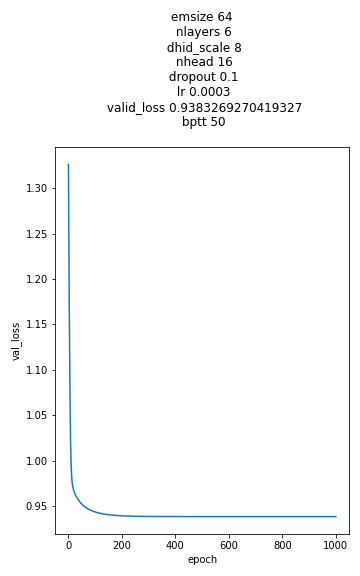

# Hyperparameter tuning

import copy
import time
import matplotlib.pyplot as plt

src_vocab_size = len(prot_vocab)
trg_vocab_size = len(ss_vocab)
emsize = 64
nlayers = 6
dhid_scale = 8
nhead = 16
dropout = 0.1
lr = 2.5

src_pad_idx = 0
trg_pad_idx = 0
max_len = 200
epochs = 100



for dhid_scale in [16]:
    for nth in [1]:
        train_data, val_data, test_data = run_batchify()

        model = Transformer(
            src_vocab_size=src_vocab_size, 
            trg_vocab_size=trg_vocab_size, 
            src_pad_idx = src_pad_idx, 
            trg_pad_idx = trg_pad_idx,
            emsize = emsize, 
            dhid_scale = dhid_scale, 
            nhead = nhead,
            dropout = dropout, 
            device = device,
            max_len = max_len
                           )
        model.to('cuda')

        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.SGD(model.parameters(), lr=lr)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 5.0, gamma=0.85)    

        best_val_loss = float('inf')
        best_model = None

        val_loss_log = []

        for epoch in range(1, epochs + 1):
            epoch_start_time = time.time()
            train(model)
            val_loss = evaluate(model, val_data)
            #val_ppl = math.exp(val_loss)
            elapsed = time.time() - epoch_start_time
            print('-' * 89)
            print(f'| end of epoch {epoch:3d} | time: {elapsed:5.2f}s | '
                  f'valid loss {val_loss:5.2f}')# | valid ppl {val_ppl:8.2f}')
            print('-' * 89)

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_model = copy.deepcopy(model)
            val_loss_log.append(val_loss)
            scheduler.step()

        test_loss = evaluate(best_model, test_data)
        #test_ppl = math.exp(test_loss)
        print('=' * 89)
        print(f'| End of training | test loss {test_loss:5.2f}')#' | '
        #      f'test ppl {test_ppl:8.2f}')
        print('=' * 89)

        test_loss = evaluate(best_model, test_data)
        plt.figure(figsize = (5,8))
        plt.plot(val_loss_log)
        plt.ylabel('val_loss')
        plt.xlabel('epoch')
        plt.title('emsize %s\n nlayers %s\n dhid_scale %s\n nhead %s\n dropout %s\n lr %s\n test_loss %s\n valid_loss %s\n bptt %s\n'\
                  %(emsize, nlayers, dhid_scale, nhead, dropout, lr, test_loss, val_loss, bptt))
        plt.tight_layout()
        plt.savefig('%s.png'%(random.randint(1,999999)))





# SS Generation

## Run all the classes first

In [9]:
import pandas as pd
import torch
from torch import nn, Tensor
import math
from typing import Tuple

In [10]:
human_df = pd.read_csv('human_df.csv',index_col = 0)
shortest = 10000
drop_list = []
for i in human_df.columns:
    seq_len = len(human_df.loc['ss',i])
    if seq_len < 201:
        drop_list.append(i)
print('%s dropped.'%(len(drop_list)))
human_df.drop(drop_list, axis = 1, inplace = True)

3746 dropped.


In [11]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
#loading tokenizers and vocab
prot_tokenizer = get_tokenizer(None)
aa = 'A C D E F G H I K L M N P Q R S T V W Y'
prot_tokenizer(aa)
prot_vocab = build_vocab_from_iterator(map(prot_tokenizer, aa))

ss_tokenizer = get_tokenizer(None)
aa = 'L H S'
ss_tokenizer(aa)
ss_vocab = build_vocab_from_iterator(map(ss_tokenizer, aa))

In [17]:
model = torch.load('./overnight_model_1000epochs') #loading model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
print('Model loaded')

Model loaded


In [19]:
#test comparison of refernece to test
index = 12
inseq = human_df.iloc[1,index][:200]
ref_ss = human_df.iloc[0,index]
inseq = [i for i in inseq]
ref_ss = ref_ss[:200]

model.eval()
inseq = torch.LongTensor([prot_vocab(prot_tokenizer(item)) for item in inseq]).to(device)
inss = torch.LongTensor([ss_vocab(ss_tokenizer('S')) for i in range(len(inseq))]).to(device)
src_mask = model.make_src_mask(inseq)
trg_mask = model.make_trg_mask(inss)
with torch.no_grad():
    outputs_encoder = model.encoder(inseq, src_mask)
    outputs_decoder = model.decoder(inss, outputs_encoder, src_mask, trg_mask)

outseq = [ss_vocab.lookup_token(ind.argmax()) for ind in outputs_decoder]
outseq = ''.join(outseq)
print(outseq)
print('-'*89)
print(ref_ss)

LHLHLSLHLLLSLHHLLLLLLLHLLSLSSHLSSSLSLLSSLLHHLHHLSLLLHLLLLLLLLLLLHSLLLLLLLSLLHSLLLLSLLLHLHHHLHLHHSSLSSHHHHSSSLSHSLSSLHLLLHHSHHSHHHLHHLSHLHHLHHLSLLHHLLLLSHHHLLLHLLLLLLLLHLHHHLLHLLLHLLLLHLHLLLLLHLLLLLSLL
-----------------------------------------------------------------------------------------
LLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLL


In [142]:
print(f'Total len - {len(human_df.columns)}')
acc_list = []
for index in range(len(human_df.columns)):
    inseq = human_df.iloc[1,index][:200]
    ref_ss = human_df.iloc[0,index]
    inseq = [i for i in inseq]
    ref_ss = ref_ss[:200]

    model.eval()
    inseq = torch.LongTensor([prot_vocab(prot_tokenizer(item)) for item in inseq]).to(device)
    inss = torch.LongTensor([ss_vocab(ss_tokenizer('S')) for i in range(len(inseq))]).to(device)
    src_mask = model.make_src_mask(inseq)
    trg_mask = model.make_trg_mask(inss)
    with torch.no_grad():
        outputs_encoder = model.encoder(inseq, src_mask)
        outputs_decoder = model.decoder(inss, outputs_encoder, src_mask, trg_mask)
    match_count = 0
    total_count = 0
    for ind in range(len(outseq)):
        total_count += 1
        if outseq[ind] == ref_ss[ind]:
            match_count += 1
        acc_list.append(match_count/total_count)
    if index % 10 == 0:
        print(index)

Total len - 19645
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
2090
2100
2110
2120
2130
2140
2150
2160
2170
218

15490
15500
15510
15520
15530
15540
15550
15560
15570
15580
15590
15600
15610
15620
15630
15640
15650
15660
15670
15680
15690
15700
15710
15720
15730
15740
15750
15760
15770
15780
15790
15800
15810
15820
15830
15840
15850
15860
15870
15880
15890
15900
15910
15920
15930
15940
15950
15960
15970
15980
15990
16000
16010
16020
16030
16040
16050
16060
16070
16080
16090
16100
16110
16120
16130
16140
16150
16160
16170
16180
16190
16200
16210
16220
16230
16240
16250
16260
16270
16280
16290
16300
16310
16320
16330
16340
16350
16360
16370
16380
16390
16400
16410
16420
16430
16440
16450
16460
16470
16480
16490
16500
16510
16520
16530
16540
16550
16560
16570
16580
16590
16600
16610
16620
16630
16640
16650
16660
16670
16680
16690
16700
16710
16720
16730
16740
16750
16760
16770
16780
16790
16800
16810
16820
16830
16840
16850
16860
16870
16880
16890
16900
16910
16920
16930
16940
16950
16960
16970
16980
16990
17000
17010
17020
17030
17040
17050
17060
17070
17080
17090
17100
17110
17120
17130
17140
1715

Text(0.5, 1.0, 'Accuracy vs Human Proteome')

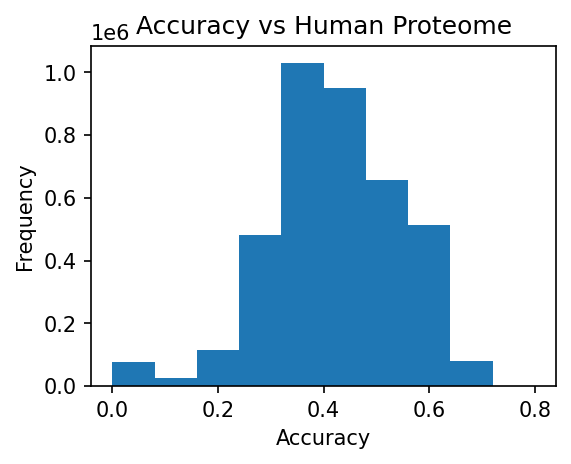

In [153]:
import matplotlib.pyplot as plt
plt.figure(figsize = (4,3), dpi = 150)
plt.hist(acc_list)
plt.xlabel('Accuracy')
plt.ylabel('Frequency')
plt.title('Accuracy vs Human Proteome')

# Prediction

In [ ]:
model = torch.load('./overnight_model_1000epochs') #loading model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
print('Model loaded')

In [ ]:
protein_sequence = ''

protein_sequence = human_df.iloc[1,index][:200]
inseq = [i for i in protein_sequence]


model.eval()
inseq = torch.LongTensor([prot_vocab(prot_tokenizer(item)) for item in inseq]).to(device)
inss = torch.LongTensor([ss_vocab(ss_tokenizer('S')) for i in range(len(inseq))]).to(device)
src_mask = model.make_src_mask(inseq)
trg_mask = model.make_trg_mask(inss)
with torch.no_grad():
    outputs_encoder = model.encoder(inseq, src_mask)
    outputs_decoder = model.decoder(inss, outputs_encoder, src_mask, trg_mask)

outseq = [ss_vocab.lookup_token(ind.argmax()) for ind in outputs_decoder]
outseq = ''.join(outseq)
print(outseq)